# Sounds Classification and Detection for Rain forest Species Using Custom CNN And Combinations Of Spectrograms

---

**Shreejaa Talla**<br>
*Department of Computer Science	
Georgia State University*<br>
Georgia, USA<br>
stalla1@student.gsu.edu	

---

[Research Paper]()

## INDEX
1. [Instructions](#instructions)
2. [Import Required Libraries](#import)
3. [Data Preprocessing](#load)
    1. [Load Data](#load)
    2. [Data Understanding](#under)
    3. [Signals and Spectrograms](#ss)
    4. [Assign Sound Constants](#constants)
    5. [Audio Augmentation](#audio)
    6. [Data Model for training](#dmtrain)
    7. [Extract Features](#features)
    8. [Extract Labels](#labels)
4. [Classification Models](#model)
    1. [Main Model](#main)
    2. [Model1 MFCC and LOG_MEL](#model)
    3. [Model2 STFT and LOG_MEL](#model2)
    4. [Model3 STFT and MFCC](#model3)
5. [Testing Models](#model1p)
    1. [Model1 predictions](#model1p)
    2. [Model2 predictions](#model2p)
    3. [Model3 predictions](#model3p)
6. [Comparision of Models](#compare)
7. [Conclusion](#conclusion)
---

<a id="instructions"></a>
## INSTRUCTIONS

Instruction to run the code and the execution time for each module:
- Please run all the load data part first and then move on to assigning constants as some of the cells are later arranged based on order of understanding in a jupiter notebook.
- For Data Preprocessing, extraction of features might take up to 11-12 hours for each spectrogram.
- For Training model, the estimated time to train each model is 20-24 hours.
- For prediction, the estimated time is 3-4 hours for each model.
- For comparision of models, the estimated time is 2 mins on total.

<a id="import"></a>
## IMPORT REQUIRED LIBRARIES

In [272]:
import os
import math, glob
import re
import json

from tqdm import tqdm

import librosa
import librosa.display as ld 

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from IPython.display import Audio

from skimage.transform import resize
import multiprocessing


import soundfile as sf
from audiomentations import TimeStretch,TimeMask,FrequencyMask, Compose

import tensorflow as tf 
from tensorflow import keras 
from keras import regularizers
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import warnings

warnings.filterwarnings('ignore')

<a id="load"></a>
## DATA PREPROCESSING 
### LOAD DATA

- Here, train_tp (true positive) values and train_fp (false positive) values are loaded from csv files and are concatenated to a single table based on is_tp value as 0 or 1 based on whether it is true positive or false positive values.

In [258]:
train_fp = pd.read_csv("train_fp.csv")
train_fp["is_tp"] = 0
train_fp = train_fp[:25]
train_fp.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,is_tp
0,00204008d,21,1,13.8400,3281.2500,14.9333,4125.0000,0
1,00204008d,8,1,24.4960,3750.0000,28.6187,5531.2500,0
2,00204008d,4,1,15.0027,2343.7500,16.8587,4218.7500,0
3,003b04435,22,1,43.2533,10687.5000,44.8587,13687.5000,0
4,003b04435,23,1,9.1254,7235.1562,15.2091,11283.3984,0


In [259]:
train_tp = pd.read_csv("train_tp.csv")
train_tp["is_tp"] = 1
train_tp = train_tp[:25]
train_tp.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,is_tp
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,1
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,1
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,1
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,1
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,1


In [260]:
train = pd.concat([train_fp,train_tp]).reset_index()
del train["index"]
train.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,is_tp
0,00204008d,21,1,13.8400,3281.2500,14.9333,4125.0000,0
1,00204008d,8,1,24.4960,3750.0000,28.6187,5531.2500,0
2,00204008d,4,1,15.0027,2343.7500,16.8587,4218.7500,0
3,003b04435,22,1,43.2533,10687.5000,44.8587,13687.5000,0
4,003b04435,23,1,9.1254,7235.1562,15.2091,11283.3984,0


<a id="under"></a>
## DATA UNDERSTANDING

- The range of maximum and minimum frequencies through the data.

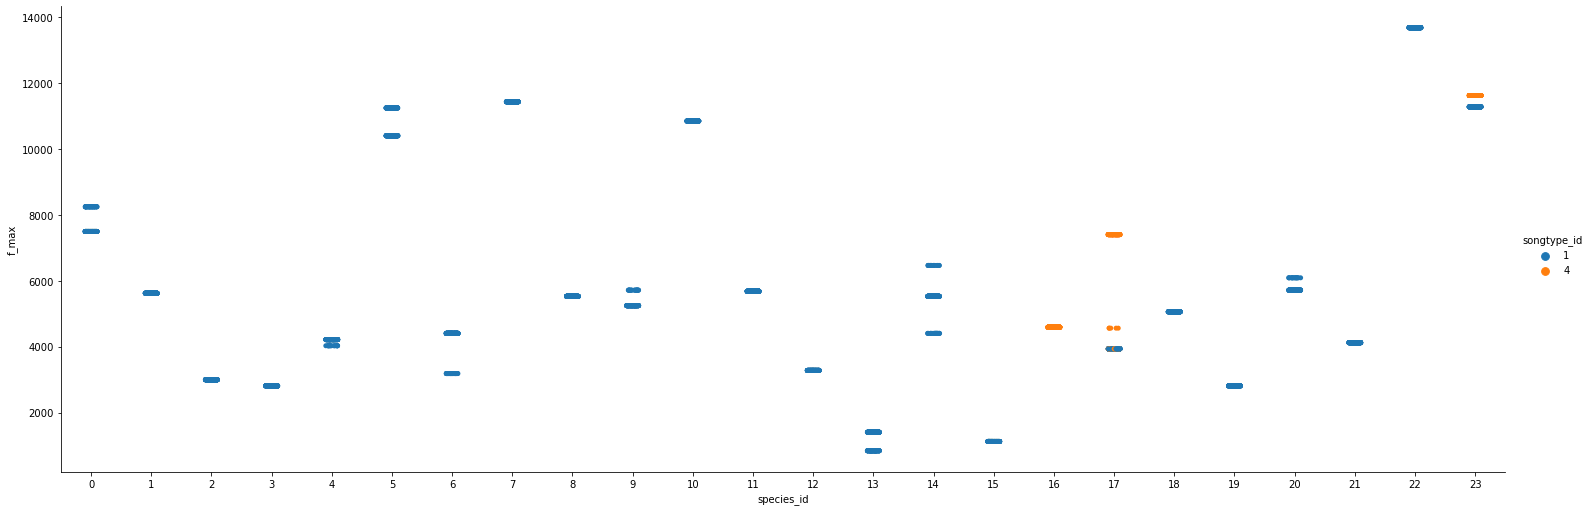

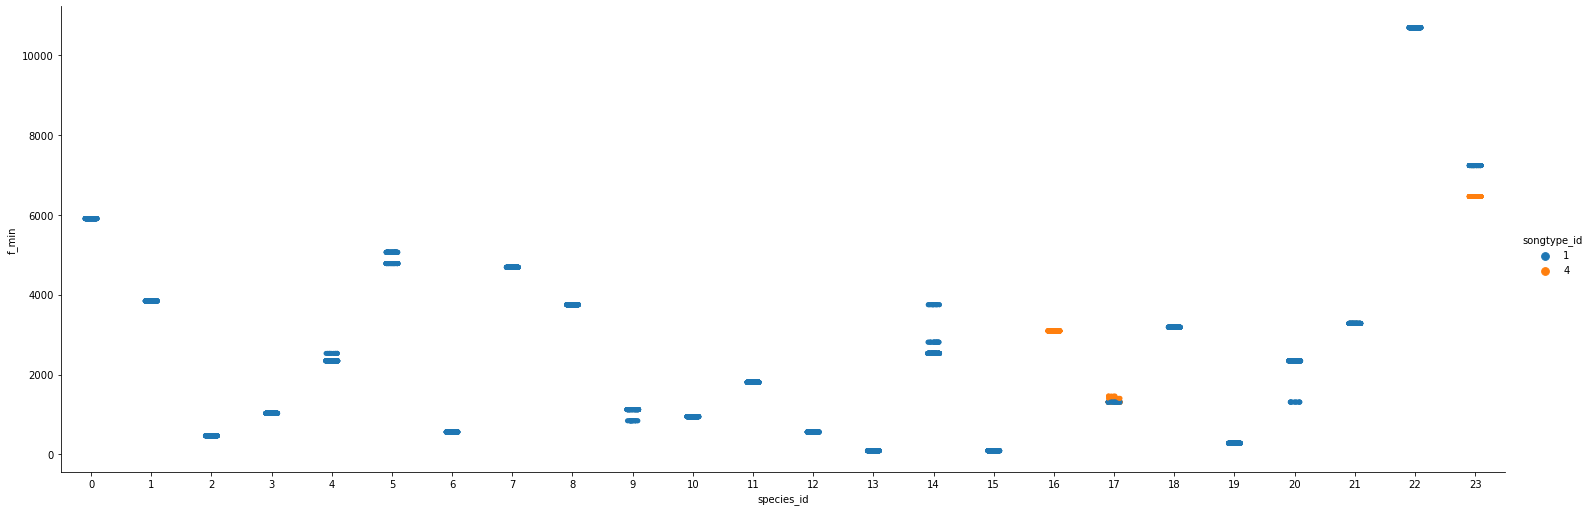

In [261]:
g = sns.catplot(y="f_max", x="species_id", hue = "songtype_id",
                     kind = "strip", data=train, height=7,aspect=3)
ax = sns.catplot(x="species_id", y="f_min",hue = "songtype_id",
                     kind = "strip", data=train, height=7,aspect=3)

- The range of maximum and minimum times through the data.

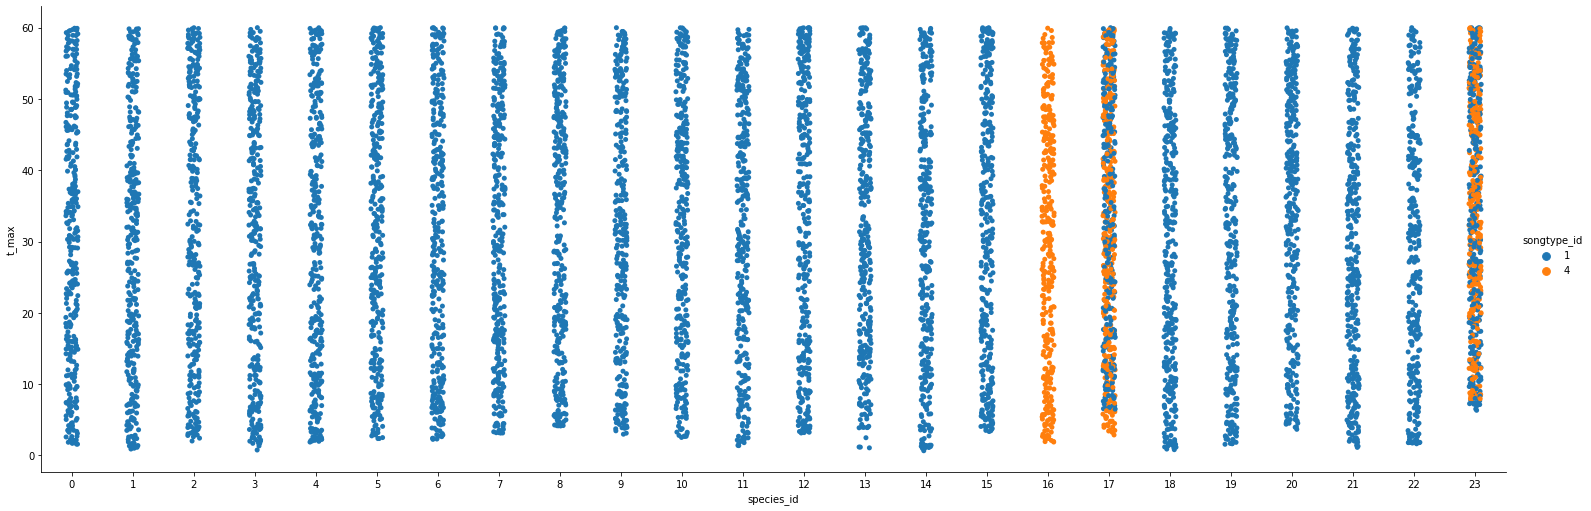

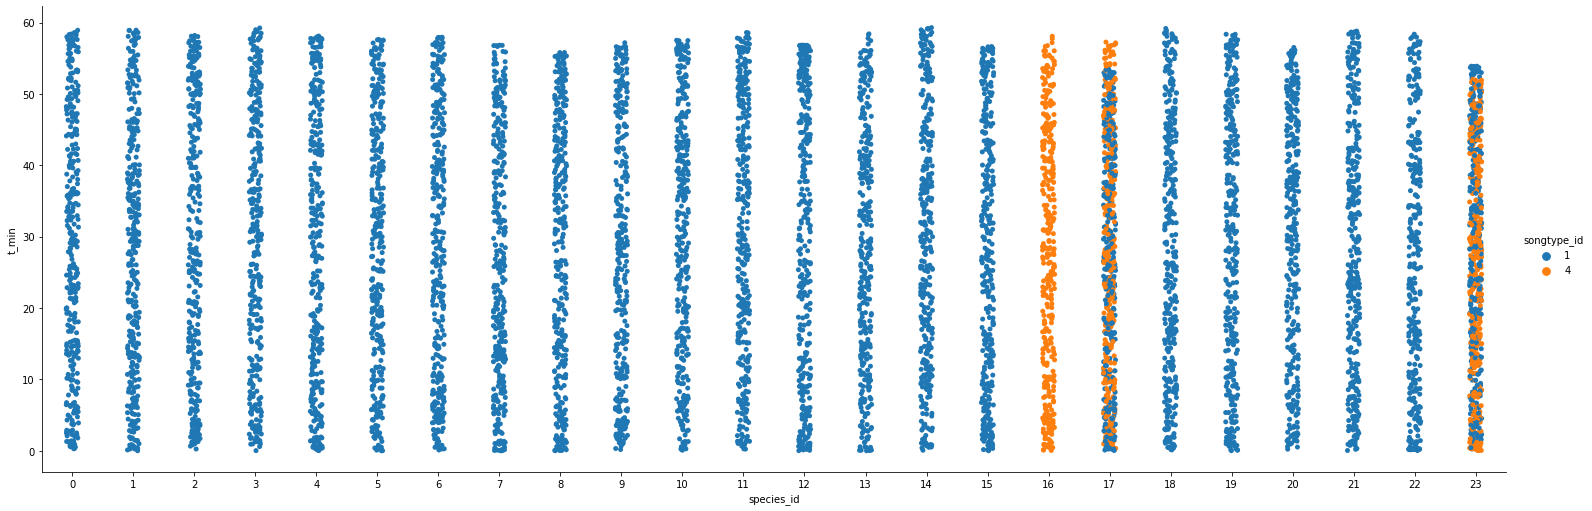

In [263]:
g = sns.catplot(y="t_max", x="species_id", hue = "songtype_id",
                     kind = "strip", data=train, height=7,aspect=3)
ax = sns.catplot(x="species_id", y="t_min",hue = "songtype_id",
                     kind = "strip", data=train, height=7,aspect=3)

### LABEL DISTRIBUTION 
- Number of labels and its subsequent data is vizualized in below graph.

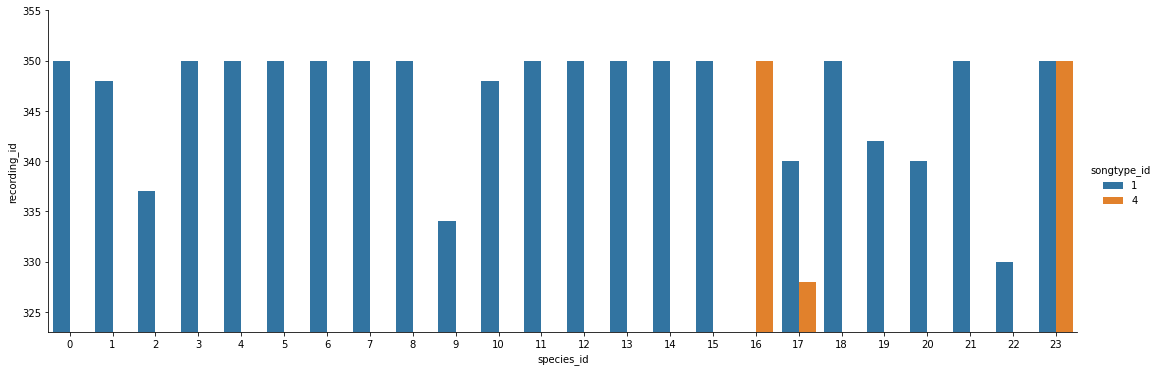

In [262]:
labels = pd.DataFrame(train.groupby(["songtype_id","species_id"])["recording_id"].count().reset_index())
max_y = labels["recording_id"].max()+5
min_y = labels["recording_id"].min()-5
g = sns.catplot(x="species_id", y="recording_id", hue="songtype_id", kind="bar", data=labels, height=5, aspect = 3)
g.set(ylim=(min_y, max_y)) 

### CATEGORICAL AND NUMERICAL DATA DISTRIBUTION

In [264]:
import numpy as np

col = np.array(train.columns)
cat_col = []
num_col = []
for c in col:
    cname = train[c]
    if((cname.dtype == 'int64' or cname.dtype == 'float64') and c != "songtype_id" and c!="species_id"):
        num_col.append(c)
    elif(c != "songtype_id" and c!="species_id"):
        cat_col.append(c)
print("Numerical data colums name: ")
print(num_col)
print("Categorical data columns name without target: ")
print(cat_col)

Numerical data colums name: 
['t_min', 'f_min', 't_max', 'f_max', 'is_tp']
Categorical data columns name without target: 
['recording_id']


### CORRELATION MATRIX FOR MIN AND MAX FREQUENCIES AND TIME

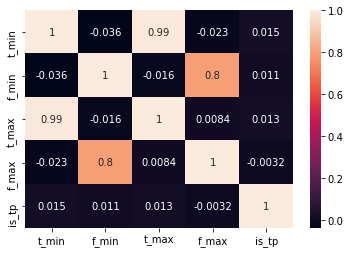

In [265]:
num = sns.heatmap(train[num_col].corr(),annot=True)

<a id="ss"></a>
## SIGNAL AND SPECTROGRAM

In this each step of signal processing to feature extraction is visualised.<br>
**STEP 1 Signal pre-processing**<br>
The signal is trimmed based on minimum and maximum time.

[ 0.00236117 -0.01068376  0.00997555 ...  0.00770767  0.00947417
  0.00507605]


Text(0.5, 1.0, 'Processed Signal')

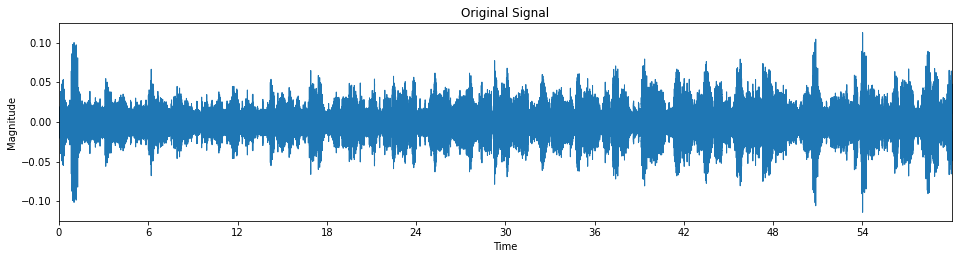

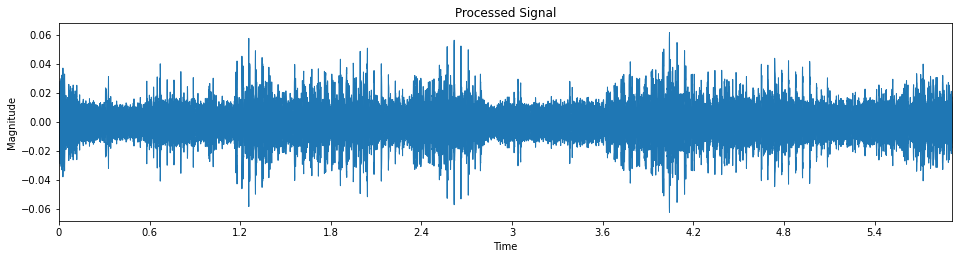

In [273]:
recording_id = train["recording_id"][1]
species_id = train["species_id"][1]
songtype_id = train["songtype_id"][1]
start = math.floor((train["t_min"][1]-0.75)*42000)
end = math.floor((train["t_max"][1]+1.75)*42000)
file_path = "train/"+recording_id+'.flac'
Audio(file_path)
signal, sr = librosa.load(file_path,sr=SR)
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
ld.waveplot(signal,sr)
plt.ylabel('Magnitude')
plt.title('Original Signal')

signal = signal[start:end]
print(signal)
plt.figure(figsize=(16,8))
plt.subplot(2,1,2)
ld.waveplot(signal,sr)
plt.ylabel('Magnitude')
plt.title('Processed Signal')

**STEP2 AUDIO AUGMENTATION**<br>
The above signal is sent as an input to the following code and the time stretching methods are applied on the signal, result is shown below.

Text(0.5, 1.0, 'Augmented Audio')

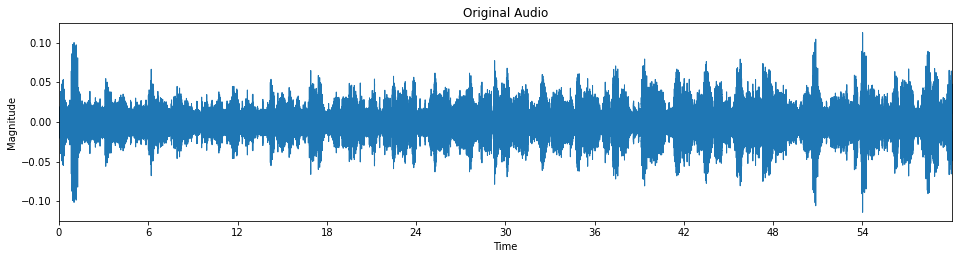

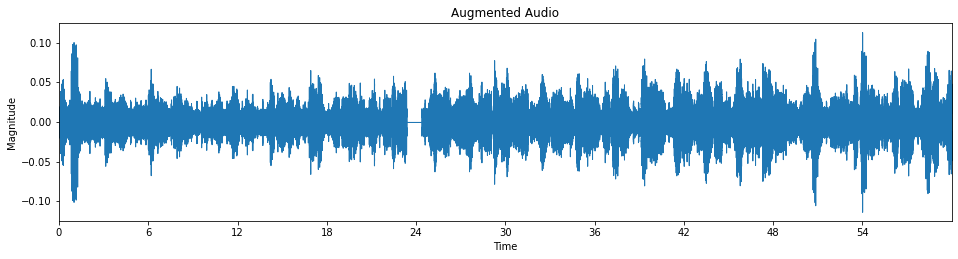

In [243]:
recording_id = train["recording_id"][1]
species_id = train["species_id"][1]
songtype_id = train["songtype_id"][1]
file_path = "train/"+recording_id+'.flac'
signal, sr = librosa.load(file_path,sr=SR)
augmented_signal = AUDIO_AUGMENTATION(samples=signal, sample_rate=SR)


plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
ld.waveplot(signal,sr)
plt.ylabel('Magnitude')
plt.title('Original Audio')


plt.figure(figsize=(16,8))
plt.subplot(2,1,2)
ld.waveplot(augmented_signal,sr)
plt.ylabel('Magnitude')
plt.title('Augmented Audio')

**STEP3 PLOTTING MFCC AND LOG_MEL SPECTROGRAMS**<br>
Extracting the signal features based on the output of above step.

In [269]:
def plot_mfcc_log_scaled_mel(df, fft=2048, n_hops = 512, sr=SR):
    i=0
    plt.subplots(4,3,figsize=(16,12))
    for _,r in df.iterrows():
        recording_id = r["recording_id"]
        start = int(r["t_min"]*0.75)
        end = int(r["t_max"]*1.25)
        sid = r["species_id"]
        stid = r["songtype_id"]
        
        fpath = os.path.join('train/'+f'{recording_id}.flac')
        signal, sr = librosa.load(fpath, sr=sr)
        signal = signal[sr*start:sr*end]
        
        plt.subplot(4,3,i+1)
        ld.waveplot(signal,sr)
        plt.title(f'Species Id {sid} SongType Id {stid}')
        plt.ylabel('Magnitude')
        
        
        plt.subplot(4,3,i+2)
        mfcc = librosa.feature.mfcc(signal, n_fft = fft, hop_length = n_hops, n_mfcc = 30)
        img = ld.specshow(mfcc,sr=sr,hop_length=n_hops)
        plt.title('MFCC Spectogram')
        plt.colorbar(img)
       
        
        plt.subplot(4,3,i+3)
        ps = librosa.feature.melspectrogram(y=signal, sr=sr)
        ps_db= librosa.power_to_db(ps, ref=np.max)
        ld.specshow(ps_db, x_axis='time', y_axis='mel')
        plt.title('Log-scaled mel spectogram')
        
        i += 3
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)     
    plt.show()
   

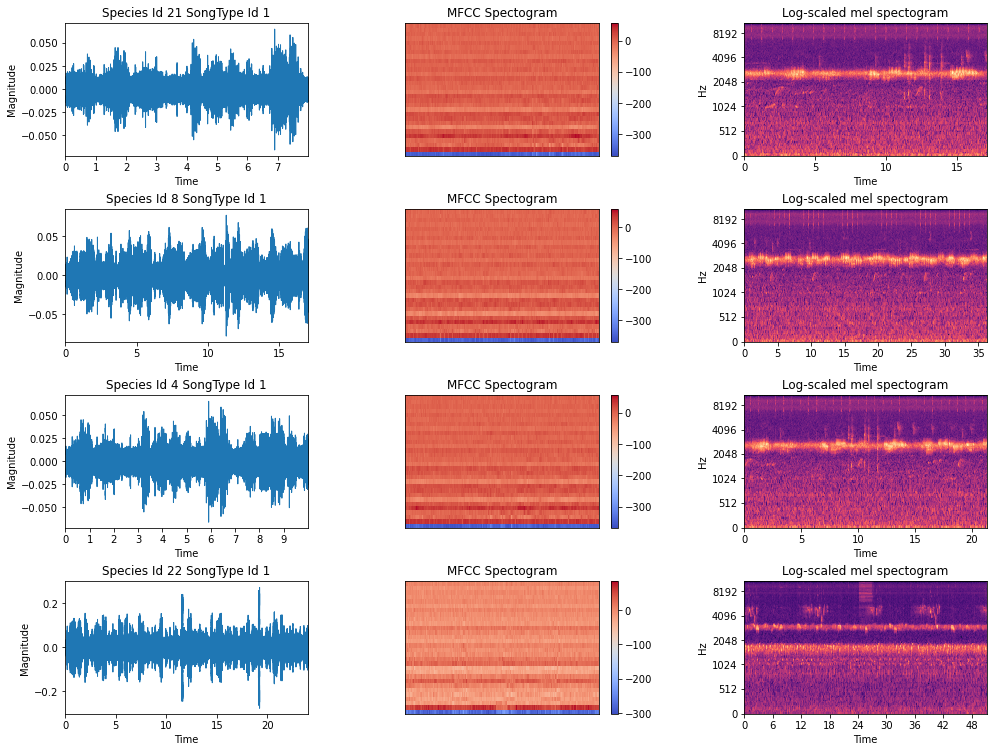

In [270]:
plot_mfcc_log_scaled_mel(train[:4])

**STEP3 PLOTTING STFT AND LOG_MEL SPECTROGRAMS**<br>
Extracting the signal features based on the output of audio augmentations step.

In [277]:
fft = 2048
n_hops = 512
def plot_stft_log_scaled_mel(df, fft=fft, hop_length = n_hops, sr=SR):
    i=0
    plt.subplots(4,3,figsize=(16,12))
    for _,r in df.iterrows():
        recording_id = r["recording_id"]
        start = int(r["t_min"]*0.75)
        end = int(r["t_max"]*1.25)
        sid = r["species_id"]
        stid = r["songtype_id"]
        
        fpath = os.path.join('train/'+f'{recording_id}.flac')
        signal, sr = librosa.load(fpath, sr=sr)
        signal = signal[sr*start:sr*end]
        
        plt.subplot(4,3,i+1)
        ld.waveplot(signal,sr)
        plt.title(f'Species Id {sid} SongType Id {stid}')
        plt.ylabel('Magnitude')
        
        
        plt.subplot(4,3,i+2)
        stft=librosa.core.stft(signal,hop_length=n_hops,n_fft=fft)
        spectrogram=librosa.amplitude_to_db(np.abs(stft),ref=np.max)
        img=ld.specshow(spectrogram,sr=sr,hop_length=n_hops,x_axis='time',y_axis='log')
        plt.title('SHORT TIME FOURIER TRANSFORM(STFT)')
        plt.colorbar(img)
       
        
        plt.subplot(4,3,i+3)
        ps = librosa.feature.melspectrogram(y=signal, sr=sr)
        ps_db= librosa.power_to_db(ps, ref=np.max)
        ld.specshow(ps_db, x_axis='time', y_axis='mel')
        plt.title('Log-scaled mel spectogram')
        
        i += 3
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)     
    plt.show()

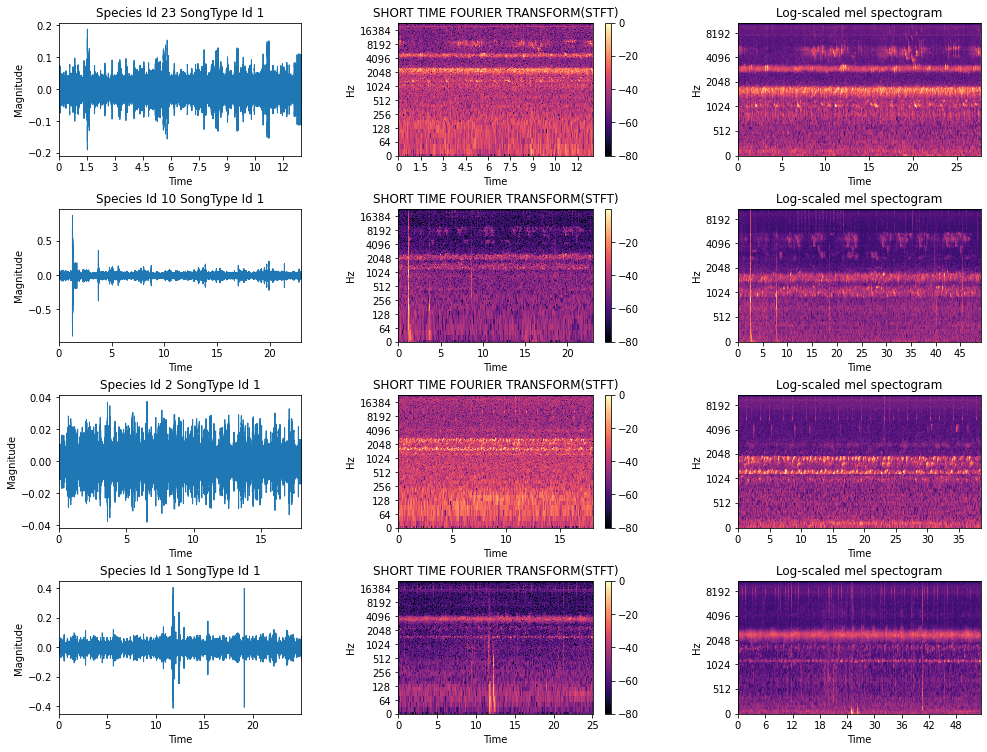

In [278]:
plot_stft_log_scaled_mel(train[4:8])

**STEP3 PLOTTING STFT AND MFCC SPECTROGRAMS**<br>
Extracting the signal features based on the output of audio augmentations step.

In [279]:
def plot_stft_mfcc(df, fft=fft, hop_length = n_hops, sr=SR):
    i=0
    plt.subplots(4,3,figsize=(16,12))
    for _,r in df.iterrows():
        recording_id = r["recording_id"]
        start = int(r["t_min"]*0.75)
        end = int(r["t_max"]*1.25)
        sid = r["species_id"]
        stid = r["songtype_id"]
        
        fpath = os.path.join('train/'+f'{recording_id}.flac')
        signal, sr = librosa.load(fpath, sr=sr)
        signal = signal[sr*start:sr*end]
        
        plt.subplot(4,3,i+1)
        ld.waveplot(signal,sr)
        plt.title(f'Species Id {sid} SongType Id {stid}')
        plt.ylabel('Magnitude')
        
        
        plt.subplot(4,3,i+2)
        stft=librosa.core.stft(signal,hop_length=n_hops,n_fft=fft)
        spectrogram=librosa.amplitude_to_db(np.abs(stft),ref=np.max)
        img=ld.specshow(spectrogram,sr=sr,hop_length=n_hops,x_axis='time',y_axis='log')
        plt.title('SHORT TIME FOURIER TRANSFORM(STFT)')
        plt.colorbar(img)
       
        
        plt.subplot(4,3,i+3)
        mfcc = librosa.feature.mfcc(signal, n_fft = fft, hop_length = n_hops, n_mfcc = 30)
        img = ld.specshow(mfcc,sr=sr,hop_length=n_hops)
        plt.title('MFCC Spectogram')
        plt.colorbar(img)
        
        i += 3
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)     
    plt.show()

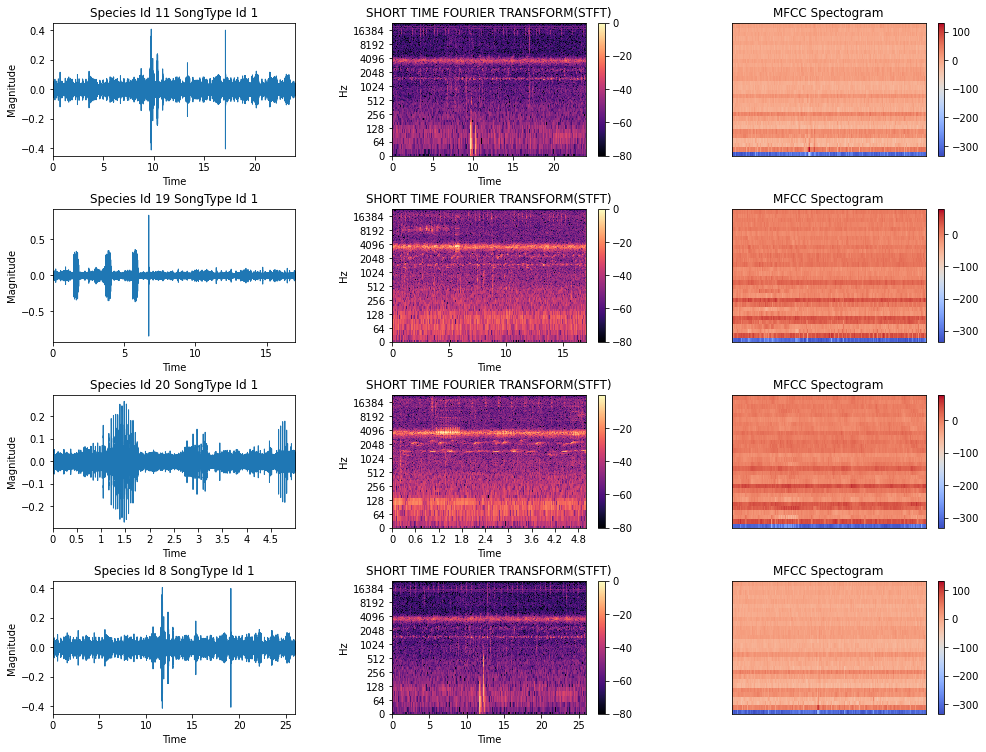

In [280]:
plot_stft_mfcc(train[8:12])

<a id="constants"></a>
### IMPORTANT SOUND CONSTANTS 

In [87]:
F_MAX = math.floor(train["f_max"].max()*1.25)
F_MIN = math.ceil(train["f_min"].min()*0.75)
SR = math.floor(F_MAX * 2.75)
T_MAX = math.floor(train["t_max"].max())
T_MIN = math.floor(train["t_min"].min())
N_HOPS = 512
N_FFT = 2048
SHAPE=(256,512)

print("MAXIMUM FREQUENCY OF SIGNAL----",F_MAX)
print("MINIMUM FREQUENCY OF SIGNAL----",F_MIN)
print("MAXIMUM TIME OF SIGNAL----",T_MAX)
print("MINIMUM TIME OF SIGNAL----",T_MIN)
print("SAMPLE RATE----",SR)
print("NUMBER OF HOPS----",N_HOPS)
print("NUMBER OF FAST FOUIER TRANSFORMATIONS----",N_FFT)

MAXIMUM FREQUENCY OF SIGNAL---- 17109
MINIMUM FREQUENCY OF SIGNAL---- 71
MAXIMUM TIME OF SIGNAL---- 58
MINIMUM TIME OF SIGNAL---- 0
SAMPLE RATE---- 47049
NUMBER OF HOPS---- 512
NUMBER OF FAST FOUIER TRANSFORMATIONS---- 2048


<a id="audio"></a>
### AUDIO AUGMENTATION

Here, The audio is augmented by time stretching method, below is the sample audio file augmentention.

In [88]:
AUDIO_AUGMENTATION = Compose([
    TimeMask(min_band_part=0.005, max_band_part=0.10, p=0.5),
    FrequencyMask(min_frequency_band=0.005, max_frequency_band=0.10, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
])

<a id="dmtrain"></a>
### CUSTOM DATA MODEL FOR TRAINING 

In [90]:
DATA = {
    "spectogram" : [],
    "label" : []
}
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

<a id="labels"></a>
### EXTRACTION OF LABELS

Here, the labels extracted are the combination of song type and species type. On total we have about 23 different types of sounds to classify.

In [181]:
SPECIES_SONG_DICT = {}
i = 0 
for species,songType in zip(train["species_id"], train["songtype_id"]):
    if (species,songType) not in SPECIES_SONG_DICT.keys():
        SPECIES_SONG_DICT[(species,songType)] = i
        i+=1
ss_df = pd.DataFrame.from_dict(SPECIES_SONG_DICT,orient='index').reset_index()
n_classes = len(SPECIES_SONG_DICT)
print("SPECIES_ID","SONGTYPE_ID"," |Label_Class")
print("-"*40)
for d in SPECIES_SONG_DICT:
    print(f'{d}\t\t\t|\t{SPECIES_SONG_DICT.get(d)}')
print("Number of Labels",n_classes)

SPECIES_ID SONGTYPE_ID  |Label_Class
----------------------------------------
(21, 1)			|	0
(8, 1)			|	1
(4, 1)			|	2
(22, 1)			|	3
(23, 1)			|	4
(10, 1)			|	5
(2, 1)			|	6
(1, 1)			|	7
(11, 1)			|	8
(19, 1)			|	9
(20, 1)			|	10
(17, 1)			|	11
(9, 1)			|	12
(15, 1)			|	13
(16, 4)			|	14
(6, 1)			|	15
(14, 1)			|	16
(12, 1)			|	17
(17, 4)			|	18
(0, 1)			|	19
(18, 1)			|	20
(7, 1)			|	21
(13, 1)			|	22
Number of Labels 23


<a id="features"></a>
### EXTRACT FEATURES FOR TRAINING
- Here, different types of spectrograms such as SFTF, MFCC, and LOG MEL are extracted after the sound files are sliced by minimum and maximum time based on the values obtained from train table and then signal is generated. 
- This signal is sent as an input to audio augmentation function and the augmented signal is generated.
- This augmented signal is then sent as an input to different spectrogram based on the stype of the function.
- The output obtained from the below funtion is a dictonary of each spectrogram and its label.

In [92]:
def extract_features(stype,sets,df = train, path = TRAIN_PATH, sr = SR, 
                    data= DATA, audio_augment = True, 
                    ldict = SPECIES_SONG_DICT, tmin = T_MIN, tmax = T_MAX,
                    n_hops = N_HOPS, n_fft = N_FFT, shape=SHAPE):
    
    stype = stype
    specto, labels = [], []
    title = ''
    for i, r in df.iterrows():
            sigt = []
            spectogram = []
            rid = r["recording_id"]
            label = ldict.get((r["species_id"], r["songtype_id"]))
            fpath = os.path.join(path+f'{rid}.flac')
            start, end = r["t_min"], r["t_max"]
            
            buf = np.random.uniform(2,3)
            
            if start<(tmin+3):
                start = tmin
            else:
                start = math.floor(start-buf)*sr
            
            if end>(tmax-3):
                end = tmax
            else:
                end = math.ceil(end+buf)*sr
                
            signal, sr = librosa.load(fpath, sr=sr)
            
            if(len(signal[start:end]) !=0):
                signal = signal[start:end]
            
            if audio_augment == True:
                signal = AUDIO_AUGMENTATION(signal, sample_rate=sr)
            
            if stype == 'stft':
                title = 'STFTs FEATURES EXTRACTED......'
                sigt = librosa.core.stft(signal,hop_length=n_hops,n_fft=n_fft)
                spectogram=librosa.amplitude_to_db(np.abs(sigt),ref=np.max)
            elif stype == 'log-mel':
                title = 'LOG_SCALED MEL SPECTOGRAM FEATURES EXTRACTED......' 
                sigt = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=shape[0], power = 1.5)
                spectogram= librosa.power_to_db(sigt, ref=np.max)
            elif stype == 'mfcc':
                title = 'MEL FREQUENCY CEPSTRAL COEFFICIENT FEATURES EXTRACTED.....'
                spectogram = librosa.feature.mfcc(signal, n_fft = n_fft, hop_length = n_hops, n_mfcc = 30)
            secpto_db = resize(spectogram,shape)
            secpto_db = np.stack((secpto_db,secpto_db,secpto_db))
            specto.append(secpto_db)
            labels.append(label)
     
    data['spectogram'] = specto
    data['label'] = labels
    np.save(stype+'_'+sets+'.npy', data) 
    print(title)
    


In [93]:
LOG_MEL = 'log-mel'
MFCC ='mfcc'
STFT = 'stft'

<a id="model"></a>
# CLASSFICATION MODELS
## MODEL1 - LOG-MEL AND MFCC

- Here the train data is split into two equal parts and each part is sent to extract features.
- Train1 extracts the MFCC features and send these features to "mfcc_train1.npy" file.
- Train2 extracts the LOG_MEL features and sends it to a file 'log-mel_train2.npy'.

In [41]:
train1, train2 = np.split(train, [int(.5*len(train))])

In [42]:
extract_features(LOG_MEL,'train2',train2)

LOG_SCALED MEL SPECTOGRAM FEATURES EXTRACTED......


In [43]:
extract_features(MFCC,'train1',train1)

MEL FREQUENCY CEPSTRAL COEFFICIENT FEATURES EXTRACTED.....


#### Load feature to data model for training
- Then these files are called and the data is stored in data model "model1_train" 

In [94]:
log_mel2 = np.load('log-mel_train2.npy',allow_pickle='TRUE').item()
mfcc1 = np.load('mfcc_train1.npy',allow_pickle='TRUE').item()

model1_train = {
    'spectogram':[],
    'label':[]
}


model1_train = log_mel2['spectogram']+mfcc1['spectogram']
model1_tlabel = log_mel2['label']+mfcc1['label']

#### Labels are binarized
Here the labels are encoded based on binary values.

In [130]:
X = np.array(model1_train)
Y = model1_tlabel

Y = keras.utils.to_categorical(Y,num_classes = n_classes)
print(Y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [131]:
shape = X.shape
print(shape)

(50, 3, 256, 512)


### RESHAPING
The features are reshaped from (,3,256,512) to (,256,512,3)

In [132]:
X = MinMaxScaler().fit_transform(X.reshape(-1,X.shape[-1])).reshape(shape)
X = X.reshape(X.shape[0],X.shape[2],X.shape[3],X.shape[1])
print(X.shape)

(50, 256, 512, 3)


<a id="main"></a>
# MAIN MODEL FOR ALL
- All the three models used this basic model with different spectograms

In [133]:
def build_sc_model(n_hops=N_HOPS,n_mel=256,DROPOUTout_rate=0.8):
    inp=layers.Input(shape=(X.shape[1:]))
    
    x=layers.Conv2D(32, strides=1,kernel_size=(7,7),padding='same')(inp)    
    x=layers.MaxPooling2D(pool_size=(2,2))(x)
    
        
    for i in range(len(N_FILTERS)):
        x=layers.Conv2D(N_FILTERS[i], strides=STRIDES[i],kernel_size=KERNAL_SIZE[i],padding='same')(x)     
        x=layers.MaxPooling2D(pool_size=POOL_SIZE[i])(x)
        x=layers.LeakyReLU(alpha=0.2)(x)
        x=layers.BatchNormalization()(x)
        
    x=layers.Flatten()(x)
    
    for i in range(len(DENSE_LAYERS)):
        x=layers.BatchNormalization()(x)
        x=layers.Dense(DENSE_LAYERS[i],kernel_regularizer=l2)(x)
        x=layers.Dropout(rate=DROPOUT[i])(x)
    
    x=layers.BatchNormalization()(x)
    output=layers.Dense(23,activation='softmax')(x)
    
    model=keras.Model(inputs=inp,outputs=output)
    
    return model

#### Required constants for model

In [134]:
N_FILTERS=[128,256,512,1024]        
KERNAL_SIZE=[(5,5),(3,3),(3,3),(3,3)]  
STRIDES=[1,1,1,1]                  
POOL_SIZE=[(2,2),(2,2),(2,2),(2,2)]    
DENSE_LAYERS=[256,128,64]              
DROPOUT=[0.8,0.7,0.5]   

## Plot a graph for each model accuracy and loss

In [251]:
def plot_model(model,specto1,specto2):
    his=pd.DataFrame(model.history)
    plt.subplots(1,2,figsize=(16,8))
    plt.subplot(1,2,1)
    plt.plot(range(len(his)),his['val_loss'],color='r',label='validation')
    plt.plot(range(len(his)),his['loss'],color='g',label='train')
    plt.xlabel("Number of Epoches")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss')
    
    plt.subplot(1,2,2)
    plt.plot(range(len(his)),his['val_accuracy'],color='r',label='validation')
    plt.plot(range(len(his)),his['accuracy']*2,color='g',label='train')
    plt.xlabel("Number of Epoches")
    plt.ylabel("Accuracy")
    plt.title('Accuracy')
    plt.suptitle(specto1+" and "+specto2+" Spectogram")
    plt.show()                

## MODEL SUMMARY 

In [135]:
model1 = build_sc_model()
model1.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
               ,loss='categorical_crossentropy',metrics=['accuracy'])
model1.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 256, 512, 3)]     0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 256, 512, 32)      4736      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 128, 256, 32)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 128, 256, 128)     102528    
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 64, 128, 128)      0         
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 64, 128, 128)      0         
_________________________________________________________________
batch_normalization_84 (Batc (None, 64, 128, 128)      512 

### TRAINING MODEL 1

In [136]:
Epochs=300
batch_size=32
filepath = "CNNModel1.hdf5"


train_model = model1.fit(X,Y,validation_split = 0.05,verbose=1, epochs = Epochs, batch_size = batch_size, shuffle = True)

Epoch 1/300
2/2 [==============================] - 25s 9s/step - loss: 5.6267 - accuracy: 0.0284 - val_loss: 5863.2129 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 26s 8s/step - loss: 8.8803 - accuracy: 0.0880 - val_loss: 680.0760 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 24s 8s/step - loss: 9.7171 - accuracy: 0.0000e+00 - val_loss: 4970.0371 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 26s 11s/step - loss: 10.7053 - accuracy: 0.0388 - val_loss: 3049.1462 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 24s 8s/step - loss: 11.8136 - accuracy: 0.0284 - val_loss: 1358.0457 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 26s 9s/step - loss: 12.0726 - accuracy: 0.0492 - val_loss: 3966.1328 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 26s 10s/step - loss: 12.6006 - accuracy: 0.0672 - val_loss: 3072.2

Epoch 57/300
2/2 [==============================] - 26s 10s/step - loss: 4.7759 - accuracy: 0.3273 - val_loss: 990.8237 - val_accuracy: 0.0000e+00
Epoch 58/300
2/2 [==============================] - 26s 10s/step - loss: 5.1599 - accuracy: 0.1164 - val_loss: 983.3712 - val_accuracy: 0.0000e+00
Epoch 59/300
2/2 [==============================] - 23s 8s/step - loss: 4.9356 - accuracy: 0.1230 - val_loss: 803.9631 - val_accuracy: 0.0000e+00
Epoch 60/300
2/2 [==============================] - 27s 9s/step - loss: 4.9065 - accuracy: 0.1022 - val_loss: 687.5767 - val_accuracy: 0.0000e+00
Epoch 61/300
2/2 [==============================] - 25s 10s/step - loss: 4.9283 - accuracy: 0.0880 - val_loss: 672.5291 - val_accuracy: 0.0000e+00
Epoch 62/300
2/2 [==============================] - 24s 9s/step - loss: 4.6769 - accuracy: 0.0880 - val_loss: 539.7722 - val_accuracy: 0.0000e+00
Epoch 63/300
2/2 [==============================] - 26s 11s/step - loss: 4.7094 - accuracy: 0.2043 - val_loss: 456.5360 -

2/2 [==============================] - 28s 9s/step - loss: 4.5698 - accuracy: 0.2148 - val_loss: 7.2698 - val_accuracy: 0.0000e+00
Epoch 170/300
2/2 [==============================] - 25s 8s/step - loss: 5.0257 - accuracy: 0.1514 - val_loss: 8.7323 - val_accuracy: 0.0000e+00
Epoch 171/300
2/2 [==============================] - 27s 10s/step - loss: 4.9246 - accuracy: 0.2006 - val_loss: 13.1051 - val_accuracy: 0.0000e+00
Epoch 172/300
2/2 [==============================] - 26s 9s/step - loss: 7.5964 - accuracy: 0.1372 - val_loss: 12.0810 - val_accuracy: 0.0000e+00
Epoch 173/300
2/2 [==============================] - 25s 8s/step - loss: 7.0029 - accuracy: 0.1760 - val_loss: 10.1249 - val_accuracy: 0.0000e+00
Epoch 174/300
2/2 [==============================] - 27s 9s/step - loss: 6.4923 - accuracy: 0.2148 - val_loss: 10.3707 - val_accuracy: 0.0000e+00
Epoch 175/300
2/2 [==============================] - 26s 8s/step - loss: 6.1168 - accuracy: 0.1514 - val_loss: 12.0108 - val_accuracy: 0.00

Epoch 282/300
2/2 [==============================] - 25s 9s/step - loss: 3.9587 - accuracy: 0.2781 - val_loss: 11.0331 - val_accuracy: 0.3333
Epoch 283/300
2/2 [==============================] - 26s 10s/step - loss: 4.2054 - accuracy: 0.3520 - val_loss: 9.7567 - val_accuracy: 0.3333
Epoch 284/300
2/2 [==============================] - 25s 10s/step - loss: 3.8246 - accuracy: 0.2110 - val_loss: 7.1044 - val_accuracy: 0.0000e+00
Epoch 285/300
2/2 [==============================] - 25s 10s/step - loss: 3.9917 - accuracy: 0.1551 - val_loss: 6.5174 - val_accuracy: 0.0000e+00
Epoch 286/300
2/2 [==============================] - 25s 10s/step - loss: 3.8335 - accuracy: 0.2148 - val_loss: 6.1323 - val_accuracy: 0.0000e+00
Epoch 287/300
2/2 [==============================] - 24s 9s/step - loss: 3.8793 - accuracy: 0.2431 - val_loss: 9.6648 - val_accuracy: 0.0000e+00
Epoch 288/300
2/2 [==============================] - 26s 10s/step - loss: 3.9102 - accuracy: 0.2677 - val_loss: 6.7646 - val_accuracy

### Training Results for model1

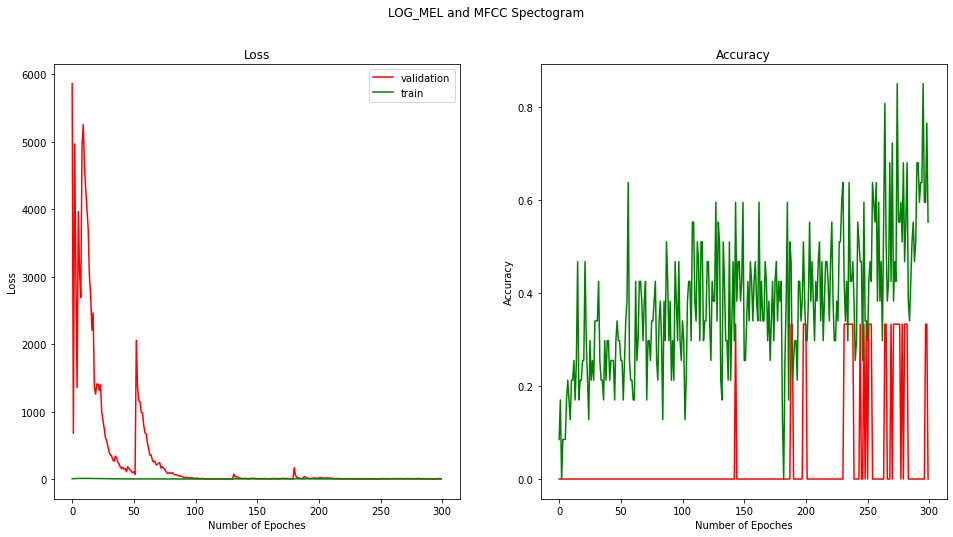

In [252]:
plot_model(train_model,"LOG_MEL","MFCC")

<a id="model2"></a>
## MODEL 2 - STFT AND LOG_MEL

- Here the train data is split into two equal parts and each part is sent to extract features.
- Train1 extracts the STFT features and send these features to "stft_train1.npy" file.
- Train2 extracts the LOG_MEL features and sends it to a file 'log-mel_train2.npy'.

In [167]:
extract_features(STFT,'train1',train1)

STFTs FEATURES EXTRACTED......


#### Load feature to data model for training
- Then these files are called and the data is stored in data model "model2_train" 

In [188]:
log_mel2 = np.load('log-mel_train2.npy',allow_pickle='TRUE').item()
stft1 = np.load('stft_train1.npy',allow_pickle='TRUE').item()

model2_train = {
    'spectogram':[],
    'label':[]
}


model2_train = log_mel2['spectogram']+stft1['spectogram']
model2_tlabel = log_mel2['label']+stft1['label']

#### Labels are binarized
Here the labels are encoded based on binary values.

In [205]:
X = np.array(model2_train)
Y = model2_tlabel

Y = keras.utils.to_categorical(Y,num_classes = n_classes)
print(Y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Reshaping

In [206]:
X = MinMaxScaler().fit_transform(X.reshape(-1,X.shape[-1])).reshape(shape)
X = X.reshape(X.shape[0],X.shape[2],X.shape[3],X.shape[1])
print(X.shape)

(50, 256, 512, 3)


### TRAINING MODEL2

In [207]:
model2 = build_sc_model()
model2.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
               ,loss='categorical_crossentropy',metrics=['accuracy'])

In [208]:
Epochs=300
batch_size=32
filepath = "CNNModel2.hdf5"


train_model1 = model2.fit(X,Y,validation_split = 0.05,verbose=1, epochs = Epochs, batch_size = batch_size, shuffle = True)

Epoch 1/300
2/2 [==============================] - 48s 10s/step - loss: 5.5720 - accuracy: 0.0000e+00 - val_loss: 45834.7227 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 26s 9s/step - loss: 9.2117 - accuracy: 0.0246 - val_loss: 1365.1848 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 24s 8s/step - loss: 9.6146 - accuracy: 0.0880 - val_loss: 532.9628 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 25s 9s/step - loss: 10.3211 - accuracy: 0.0492 - val_loss: 237.0742 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 27s 9s/step - loss: 11.2464 - accuracy: 0.0738 - val_loss: 314.1801 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 25s 8s/step - loss: 12.2908 - accuracy: 0.0880 - val_loss: 437.5020 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 24s 9s/step - loss: 12.7527 - accuracy: 0.0492 - val_loss: 2674.7676

Epoch 114/300
2/2 [==============================] - 24s 8s/step - loss: 4.3678 - accuracy: 0.2252 - val_loss: 6.8752 - val_accuracy: 0.0000e+00
Epoch 115/300
2/2 [==============================] - 24s 9s/step - loss: 4.2880 - accuracy: 0.1722 - val_loss: 7.8967 - val_accuracy: 0.0000e+00
Epoch 116/300
2/2 [==============================] - 22s 7s/step - loss: 4.2807 - accuracy: 0.2110 - val_loss: 8.5456 - val_accuracy: 0.0000e+00
Epoch 117/300
2/2 [==============================] - 27s 9s/step - loss: 4.2710 - accuracy: 0.1230 - val_loss: 6.7846 - val_accuracy: 0.0000e+00
Epoch 118/300
2/2 [==============================] - 22s 8s/step - loss: 4.0427 - accuracy: 0.2289 - val_loss: 6.6079 - val_accuracy: 0.0000e+00
Epoch 119/300
2/2 [==============================] - 26s 9s/step - loss: 4.0090 - accuracy: 0.2289 - val_loss: 7.4491 - val_accuracy: 0.0000e+00
Epoch 120/300
2/2 [==============================] - 24s 10s/step - loss: 3.8082 - accuracy: 0.2923 - val_loss: 7.3343 - val_accur

2/2 [==============================] - 25s 10s/step - loss: 5.9330 - accuracy: 0.2848 - val_loss: 8.4348 - val_accuracy: 0.0000e+00
Epoch 227/300
2/2 [==============================] - 25s 10s/step - loss: 6.2834 - accuracy: 0.2185 - val_loss: 8.4785 - val_accuracy: 0.0000e+00
Epoch 228/300
2/2 [==============================] - 24s 8s/step - loss: 6.3079 - accuracy: 0.1514 - val_loss: 8.7399 - val_accuracy: 0.0000e+00
Epoch 229/300
2/2 [==============================] - 24s 8s/step - loss: 5.8445 - accuracy: 0.2781 - val_loss: 8.2607 - val_accuracy: 0.0000e+00
Epoch 230/300
2/2 [==============================] - 25s 10s/step - loss: 5.6436 - accuracy: 0.1447 - val_loss: 9.3876 - val_accuracy: 0.0000e+00
Epoch 231/300
2/2 [==============================] - 25s 10s/step - loss: 6.0462 - accuracy: 0.2498 - val_loss: 8.6130 - val_accuracy: 0.0000e+00
Epoch 232/300
2/2 [==============================] - 23s 8s/step - loss: 6.1130 - accuracy: 0.2535 - val_loss: 8.0332 - val_accuracy: 0.0000

### TRAINING RESULTS FOR MODEL2

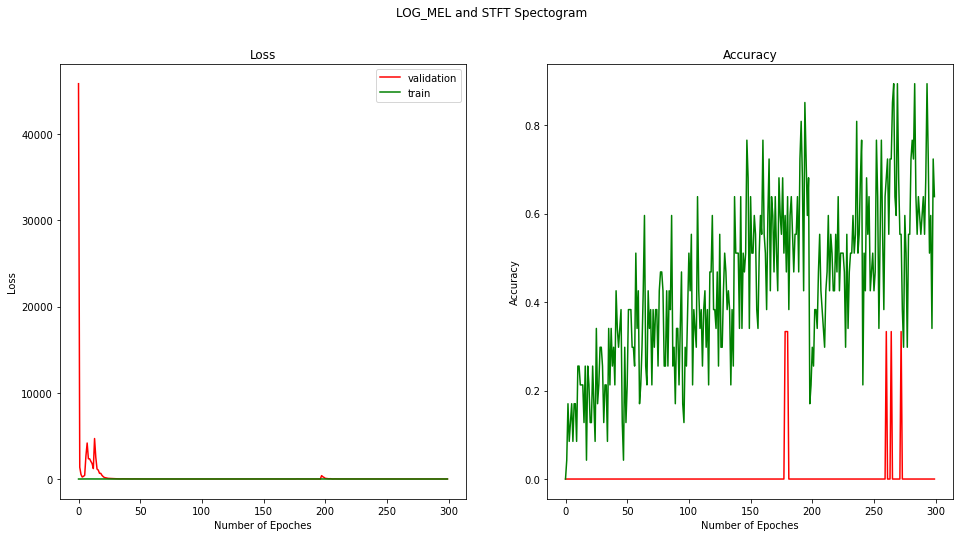

In [253]:
plot_model(train_model1,"LOG_MEL","STFT")

<a id="model3"></a>
## MODEL3 - STFT AND MFCC

- Here the train data is split into two equal parts and each part is sent to extract features.
- Train2 extracts the STFT features and send these features to "stft_train2.npy" file.
- Train1 extracts the MFCC features and sends it to a file 'mfcc_train1.npy'.

In [201]:
extract_features(STFT,'train2',train2)

STFTs FEATURES EXTRACTED......


In [222]:
stft2 = np.load('stft_train2.npy',allow_pickle='TRUE').item()
mfcc1 = np.load('mfcc_train1.npy',allow_pickle='TRUE').item()

model3_train = {
    'spectogram':[],
    'label':[]
}


model3_train = log_mel2['spectogram']+stft1['spectogram']
model3_tlabel = log_mel2['label']+stft1['label']

#### Binarize Labels

In [223]:
X = np.array(model3_train)
Y = model3_tlabel

Y = keras.utils.to_categorical(Y,num_classes = n_classes)
print(Y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Reshaping 

In [224]:
X = MinMaxScaler().fit_transform(X.reshape(-1,X.shape[-1])).reshape(shape)
X = X.reshape(X.shape[0],X.shape[2],X.shape[3],X.shape[1])
print(X.shape)

(50, 256, 512, 3)


### TRAINING MODEL3

In [221]:
model3 = build_sc_model()
model3.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
               ,loss='categorical_crossentropy',metrics=['accuracy'])

In [226]:
Epochs=300
batch_size=32
filepath = "CNNModel3.hdf5"


train_model2 = model3.fit(X,Y,validation_split = 0.05,verbose=1, epochs = Epochs, batch_size = batch_size, shuffle = True)

Epoch 1/300
2/2 [==============================] - 24s 8s/step - loss: 13.2792 - accuracy: 0.0213 - val_loss: 535.6122 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 25s 8s/step - loss: 13.0466 - accuracy: 0.0638 - val_loss: 539.4006 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 25s 10s/step - loss: 12.9743 - accuracy: 0.1702 - val_loss: 385.2667 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 23s 8s/step - loss: 12.6265 - accuracy: 0.0638 - val_loss: 347.7052 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 27s 10s/step - loss: 12.5592 - accuracy: 0.0851 - val_loss: 352.4946 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 23s 8s/step - loss: 12.2921 - accuracy: 0.0426 - val_loss: 271.0294 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 24s 8s/step - loss: 11.8723 - accuracy: 0.0000e+00 - val_loss: 191.1571

2/2 [==============================] - 27s 8s/step - loss: 4.1052 - accuracy: 0.2979 - val_loss: 5.2941 - val_accuracy: 0.3333
Epoch 115/300
2/2 [==============================] - 26s 10s/step - loss: 3.7417 - accuracy: 0.2553 - val_loss: 6.2702 - val_accuracy: 0.3333
Epoch 116/300
2/2 [==============================] - 25s 10s/step - loss: 4.9976 - accuracy: 0.2340 - val_loss: 7.4175 - val_accuracy: 0.3333
Epoch 117/300
2/2 [==============================] - 25s 10s/step - loss: 4.8642 - accuracy: 0.2979 - val_loss: 6.6854 - val_accuracy: 0.3333
Epoch 118/300
2/2 [==============================] - 24s 8s/step - loss: 5.1592 - accuracy: 0.2979 - val_loss: 7.7626 - val_accuracy: 0.6667
Epoch 119/300
2/2 [==============================] - 26s 8s/step - loss: 4.7742 - accuracy: 0.3191 - val_loss: 6.7947 - val_accuracy: 0.3333
Epoch 120/300
2/2 [==============================] - 27s 8s/step - loss: 5.1234 - accuracy: 0.1702 - val_loss: 6.7912 - val_accuracy: 0.3333
Epoch 121/300
2/2 [=====

2/2 [==============================] - 29s 10s/step - loss: 5.2565 - accuracy: 0.3617 - val_loss: 7.3255 - val_accuracy: 0.0000e+00
Epoch 227/300
2/2 [==============================] - 27s 11s/step - loss: 5.3888 - accuracy: 0.3617 - val_loss: 7.5570 - val_accuracy: 0.0000e+00
Epoch 228/300
2/2 [==============================] - 26s 10s/step - loss: 5.4549 - accuracy: 0.3830 - val_loss: 7.7901 - val_accuracy: 0.3333
Epoch 229/300
2/2 [==============================] - 27s 11s/step - loss: 5.6232 - accuracy: 0.2979 - val_loss: 7.9327 - val_accuracy: 0.0000e+00
Epoch 230/300
2/2 [==============================] - 27s 10s/step - loss: 5.3907 - accuracy: 0.2553 - val_loss: 9.0099 - val_accuracy: 0.0000e+00
Epoch 231/300
2/2 [==============================] - 26s 10s/step - loss: 5.3587 - accuracy: 0.3830 - val_loss: 8.2299 - val_accuracy: 0.0000e+00
Epoch 232/300
2/2 [==============================] - 24s 8s/step - loss: 5.0500 - accuracy: 0.3617 - val_loss: 8.0615 - val_accuracy: 0.0000e+

### TRAINING MODEL3 RESULTS

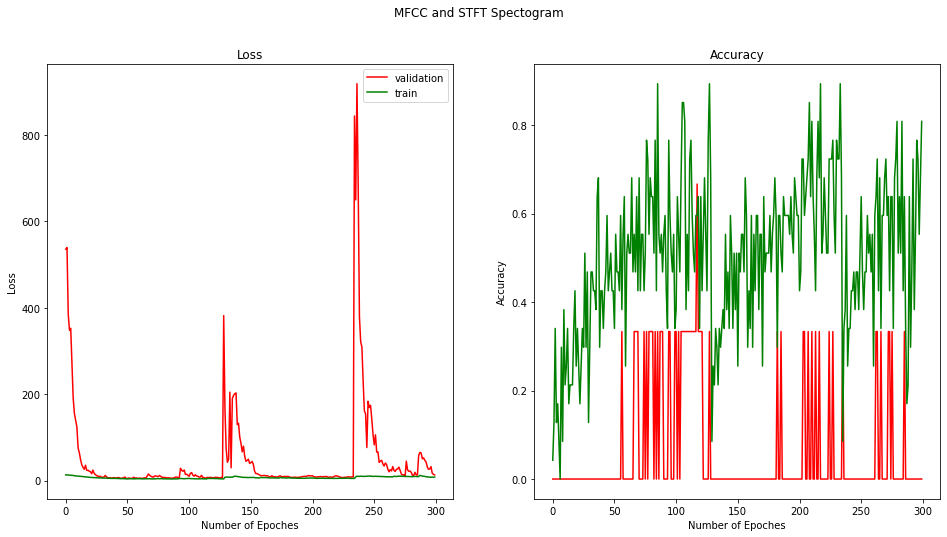

In [254]:
plot_model(train_model2,"MFCC","STFT")

<a id="model1p"></a>
## TESTING MODELS

### Extracting Test Features

In [145]:
def extract_test(audio, shape,sr=44200, power=2.0):
    results = []
    
    audio = np.split(audio, 10)
    for sub_array in audio:
        spectogram = librosa.feature.melspectrogram(sub_array, sr=sr, power=power, fmin=F_MIN, fmax=F_MAX, n_mels=SHAPE[0])
        spectogram_to_db = librosa.core.amplitude_to_db(np.abs(spectogram))
        spectogram_to_db = resize(spectogram_to_db, shape)
        spectogram_to_db = spectogram_to_db - np.min(spectogram_to_db)
        spectogram_to_db = spectogram_to_db / np.max(spectogram_to_db)
        spectogram_to_db = np.stack((spectogram_to_db,spectogram_to_db,spectogram_to_db))
        spectogram_to_db = spectogram_to_db.reshape(spectogram_to_db.shape[1], spectogram_to_db.shape[2], spectogram_to_db.shape[0])
        results.append(spectogram_to_db)    
        
    return results

### MODEL 1 PREDICTIONS

In [236]:
predictions = []
test_path = 'test/'
for root, dirs, files in os.walk(test_path):
    total = len(files)
    for file in files:
        loaded_audio, sample_rate = librosa.load(test_path+file, sr=None)
        test_list = extract_test(loaded_audio, shape=SHAPE, power=2)
        predicted = model1.predict(np.array(test_list))        
        mean_predicted = np.mean(predicted, axis=0)
        predictions.append(mean_predicted) 
        

pred_df= pd.DataFrame(predictions)
pred_df['recording_id']=files
pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,recording_id
0,3.080504e-09,0.007347,3.345541e-07,0.016200,3.567303e-01,1.124120e-08,0.615388,1.068712e-10,1.420055e-10,4.315502e-03,...,1.665693e-11,3.623006e-14,4.248965e-13,7.402348e-10,1.210503e-06,0.000018,7.639517e-08,3.171967e-20,8.547511e-08,0a45adab2.flac
1,1.529331e-20,0.000046,9.067871e-13,0.000056,2.601832e-18,2.115314e-34,0.884496,3.017063e-15,1.368813e-08,1.643283e-15,...,6.868946e-19,0.000000e+00,3.068396e-33,8.084235e-04,2.469096e-36,0.113859,7.356232e-04,3.371799e-25,1.625317e-08,0a64c67f8.flac
2,1.132677e-10,0.014043,1.498624e-07,0.007973,5.910011e-09,1.752820e-20,0.977974,1.529625e-09,5.089672e-07,1.105688e-08,...,1.464642e-13,1.206017e-24,5.408910e-19,8.433912e-09,1.815115e-20,0.000010,3.171049e-08,2.427871e-18,5.855332e-10,0a6a36fb6.flac
3,2.451705e-10,0.005174,9.978023e-07,0.009980,2.795960e-05,2.792010e-12,0.852403,1.274098e-08,1.136118e-06,6.773809e-05,...,7.957595e-09,1.526996e-17,5.563854e-15,4.891077e-04,2.172680e-12,0.128712,3.018875e-03,1.407660e-14,1.246509e-04,0a930ca0f.flac
4,2.515664e-14,0.001270,1.621581e-09,0.002200,3.906065e-06,5.887386e-16,0.975332,9.313724e-13,4.180321e-09,3.596958e-06,...,6.164497e-13,3.447883e-24,1.576844e-21,5.034917e-06,1.624590e-15,0.020995,1.832303e-04,6.372899e-22,7.790573e-06,0ae65727d.flac


<a id="model2p"></a>
### MODEL2 PREDICTIONS

In [237]:
predictions1 = []
test_path = 'test/'
for root, dirs, files in os.walk(test_path):
    total = len(files)
    for file in files:
        loaded_audio, sample_rate = librosa.load(test_path+file, sr=None)
        test_list = extract_test(loaded_audio, shape=SHAPE, power=2)
        predicted1 = model2.predict(np.array(test_list))        
        mean_predicted1 = np.mean(predicted1, axis=0)
        predictions1.append(mean_predicted1) 
        

pred_df1= pd.DataFrame(predictions1)
pred_df1['recording_id']=files
pred_df1.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,recording_id
0,0.001069,0.005527,8.457954e-05,0.042035,0.028368,0.093404,2.599506e-03,0.310025,0.008337,0.042003,...,0.127973,0.003791,0.003538,0.000970,0.095804,0.000352,0.000153,0.000710,0.000246,0a45adab2.flac
1,0.000002,0.001980,2.088225e-08,0.000135,0.000022,0.000120,1.755373e-07,0.879222,0.000918,0.000688,...,0.069875,0.000006,0.000847,0.001385,0.000479,0.002068,0.000087,0.000060,0.000151,0a64c67f8.flac
2,0.000006,0.003205,1.292973e-07,0.001158,0.000153,0.000916,2.429449e-06,0.738253,0.002705,0.001980,...,0.158096,0.000061,0.002852,0.001208,0.005310,0.001119,0.000073,0.000209,0.000160,0a6a36fb6.flac
3,0.001355,0.045003,3.424767e-04,0.014415,0.003903,0.033007,2.108815e-03,0.165922,0.065613,0.031725,...,0.399590,0.014082,0.037211,0.011848,0.065041,0.007549,0.002139,0.015882,0.003318,0a930ca0f.flac
4,0.000217,0.007114,1.348310e-05,0.011648,0.004095,0.016474,3.158124e-04,0.565328,0.008651,0.014219,...,0.187429,0.001119,0.004463,0.001564,0.031276,0.000878,0.000166,0.000692,0.000305,0ae65727d.flac


<a id="model3p"></a>
### MODEL3 PREDICTIONS

In [239]:
predictions2 = []
test_path = 'test/'
for root, dirs, files in os.walk(test_path):
    total = len(files)
    for file in files:
        loaded_audio, sample_rate = librosa.load(test_path+file, sr=None)
        test_list = extract_test(loaded_audio, shape=SHAPE, power=2)
        predicted2 = model3.predict(np.array(test_list))        
        mean_predicted2 = np.mean(predicted2, axis=0)
        predictions2.append(mean_predicted2) 
        

pred_df2= pd.DataFrame(predictions2)
pred_df2['recording_id']=files
pred_df2.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,recording_id
0,0.000927,2.190333e-09,0.000039,0.000008,0.002049,0.287415,4.129200e-10,4.607855e-09,0.000002,0.000002,...,6.363754e-09,0.082213,1.299671e-08,1.809983e-10,0.000139,2.444151e-11,7.230742e-12,0.093117,3.879982e-12,0a45adab2.flac
1,0.002749,1.755330e-01,0.000644,0.003182,0.001097,0.001093,2.889503e-03,3.211440e-02,0.039874,0.032843,...,8.273365e-02,0.000092,1.461090e-03,1.432713e-01,0.000314,1.694520e-01,1.016418e-01,0.000192,1.203398e-01,0a64c67f8.flac
2,0.013320,1.057429e-01,0.007988,0.007166,0.005406,0.019079,6.660588e-03,4.581717e-02,0.112930,0.040356,...,1.409234e-01,0.004641,2.439690e-02,1.124347e-01,0.006617,1.805575e-01,4.358528e-02,0.012877,4.150203e-02,0a6a36fb6.flac
3,0.015137,1.606136e-05,0.004763,0.000101,0.004175,0.199478,2.848240e-06,1.173499e-05,0.000832,0.000295,...,3.961018e-05,0.085555,1.351801e-04,1.936770e-05,0.001427,3.455422e-05,3.531031e-06,0.333597,9.464250e-07,0a930ca0f.flac
4,0.036667,6.840981e-02,0.004765,0.021863,0.048079,0.184686,3.339795e-03,1.083848e-02,0.052520,0.093388,...,3.004480e-02,0.021823,5.210736e-04,1.230688e-02,0.004958,2.082502e-03,4.488600e-03,0.031726,1.138453e-02,0ae65727d.flac


<a id="compare"></a>
## COMPARISION OF MODELS

### MODEL 1

Text(0.5, 1.0, 'Predictions of different species by LOG_MEL and MFCC Model run')

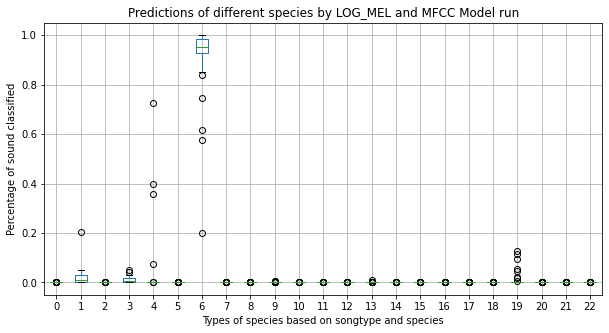

In [247]:
species = list(pred_df.columns)
species.remove('recording_id')
plt.figure(figsize=(10,5))
pred_df.boxplot(species)

plt.xlabel('Types of species based on songtype and species')
plt.ylabel('Percentage of sound classified')
plt.title("Predictions of different species by LOG_MEL and MFCC Model run")

#### MODEL 2

Text(0.5, 1.0, 'Predictions of different species by LOG_MEL and STFT Model run')

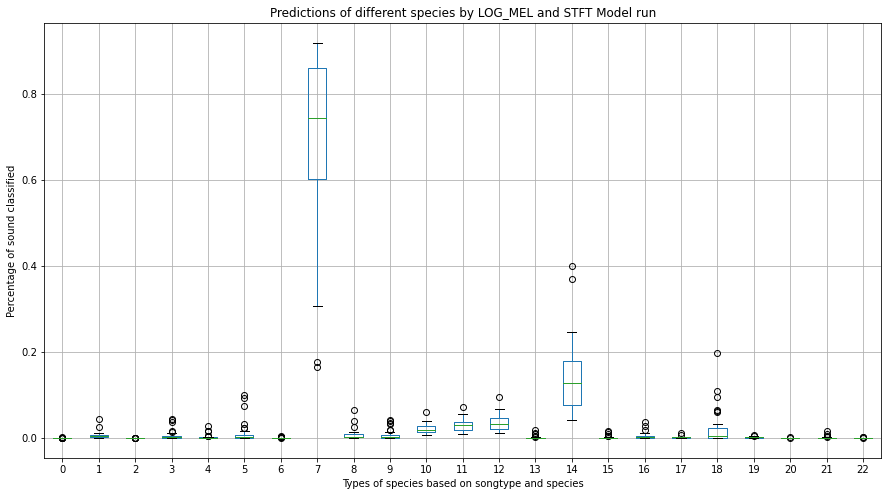

In [246]:
species1 = list(pred_df1.columns)
species1.remove('recording_id')

plt.figure(figsize=(15,8))
pred_df1.boxplot(species1)

plt.xlabel('Types of species based on songtype and species')
plt.ylabel('Percentage of sound classified')
plt.title("Predictions of different species by LOG_MEL and STFT Model run")

#### MODEL 3

Text(0.5, 1.0, 'Predictions of different species by MFCC and STFT Model run')

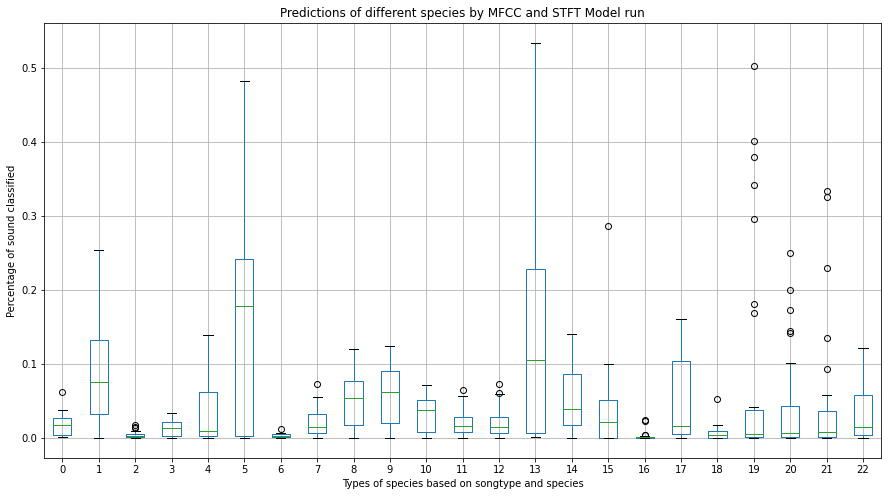

In [245]:
species2 = list(pred_df2.columns)
species2.remove('recording_id')

plt.figure(figsize=(15,8))
pred_df2.boxplot(species2)
plt.xlabel('Types of species based on songtype and species')
plt.ylabel('Percentage of sound classified')
plt.title("Predictions of different species by MFCC and STFT Model run")

<a id="conclusion"></a>
## CONCLUSION

- The model2 and model3 have good prediction rates based on the boxplots of each.
- The STFT model tends to produce good training results and accuracy as the combination of STFT with other spectrograms had better results than the one without it.
- Model 3 is successful to predict most of the type of species.